## Imports

In [1]:
from plio.io import io_controlnetwork
from knoten.csm import create_csm
from scipy import sparse
import ale
import csmapi
import os
import numpy as np

/home/ladoramkershner/miniconda3/envs/csm_local/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


In [2]:
os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"
os.environ["ISIS3DATA"] = "/usgs/cpkgs/isis3/data"
from pysis import isis

### Point to your Network (Only Variables that vary cnet to cnet)

In [3]:
network = 'data_lak/hand_dense.net'
cubes = 'data_lak/cubes.lis'

### Load Network

In [4]:
df = io_controlnetwork.from_isis(network)
# df = df[df['serialnumber'] == 'MRO/CTX/1085197697:073']
# df['serialnumber'].unique()
df

,id,pointType,pointChoosername,pointDatetime,pointEditLock,pointIgnore,pointJigsawRejected,referenceIndex,aprioriSurfPointSource,aprioriSurfPointSourceFile,...,measureDatetime,measureEditLock,measureIgnore,measureJigsawRejected,diameter,apriorisample,aprioriline,samplesigma,linesigma,measureLog
0,autoseed_001,2,autoseed,2019-12-06T10:19:12,False,False,False,0,0,,...,2019-12-06T10:19:12,False,False,False,0.0,201.356777,302.569131,0.0,0.0,[]
1,autoseed_001,2,autoseed,2019-12-06T10:19:12,False,False,False,0,0,,...,2019-12-06T10:19:12,False,False,False,0.0,754.094710,15168.130157,0.0,0.0,[]
2,autoseed_001,2,autoseed,2019-12-06T10:19:12,False,False,False,0,0,,...,2019-12-06T10:19:12,False,False,False,0.0,399.936010,13312.074608,0.0,0.0,[]
3,autoseed_002,2,autoseed,2019-12-06T10:19:12,False,False,False,0,0,,...,2019-12-06T10:19:12,False,False,False,0.0,1926.464206,96.383931,0.0,0.0,[]
4,autoseed_002,2,autoseed,2019-12-06T10:19:12,False,False,False,0,0,,...,2019-12-06T10:19:12,False,False,False,0.0,2100.233957,14938.826738,0.0,0.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,hand_15,2,ladoramkershner,2019-12-11T16:05:47,False,False,False,0,0,,...,2019-12-11T16:05:47,False,False,False,0.0,2413.917268,22462.671510,0.0,0.0,[]
126,hand_15,2,ladoramkershner,2019-12-11T16:05:47,False,False,False,0,0,,...,2019-12-11T16:05:47,False,False,False,0.0,2445.984758,24263.903615,0.0,0.0,[]
127,hand_16,2,ladoramkershner,2019-12-12T08:09:54,False,False,False,1,0,,...,2019-12-12T08:09:54,False,False,False,0.0,3843.915024,24115.819511,0.0,0.0,[]
128,hand_16,2,ladoramkershner,2019-12-12T08:09:54,False,False,False,1,0,,...,2019-12-12T08:09:54,False,False,False,0.0,4009.638555,9314.698759,0.0,0.0,[]


### Generate Sensors and Ground Points
#### For some reason, autoseed does not generate ground points for the control network, we have to calculate

In [5]:
def generate_sensors(cubes):
    isd_files = []
    sensors = {}
    for line in open(cubes):
        basename = os.path.splitext(os.path.basename(line.strip()))[0]
        isd = os.path.join('data_lak',basename+'.json')
        isd_files.append(isd)
        with open(isd, 'w+') as f:
            f.write(ale.loads(line.strip(), formatter='usgscsm'))

        sn = isis.getsn(from_=line.strip()).strip().decode('utf-8')
        sensors[sn] = create_csm(isd)
    return sensors

def compute_ground_points_closestApproachDistance(df, sensors):
    '''
    df: control network data frame
    sensors: dict mapping serial numbers to CSM sensor models

    returns: dict mapping point IDs to ground points
    '''
    ground_points = {}
    for point_id, group in df.groupby('id'):
        num_measures = len(group)
        design_mat = np.zeros((num_measures*3,3))
        rhs = np.zeros((num_measures*3))
        for i in range(num_measures):
            row = group.iloc[i]
            measure = csmapi.ImageCoord(row['line'], row['sample'])
            locus = sensors[row['serialnumber']].imageToRemoteImagingLocus(measure)
            a = np.array([locus.point.x, locus.point.y, locus.point.z])
            d = np.array([locus.direction.x, locus.direction.y, locus.direction.z])
            d = d / np.linalg.norm(d)
            design_mat[3*i:3*i+3] = np.identity(3) - np.matmul(np.reshape(d, (3,1)), np.reshape(d,(1,3)))
            rhs[3*i:3*i+3] = np.dot(a,d)*d - a
        normal_mat = np.dot(design_mat.T, design_mat)
        ground_points[point_id] = np.dot(np.linalg.inv(normal_mat), np.dot(design_mat.T, rhs))
    return ground_points

def compute_ground_points_projection(df, sensors, height):
    ground_points = {}
    for point_id, group in df.groupby('id'):
        num_measures = len(group)
        measure_ground = []
        for i in range(num_measures):
            row = group.iloc[i]
            measure = csmapi.ImageCoord(row['line'], row['sample'])
            height = 3388850.23708615 # average of camstats average <meters>
            measure_ground.append(sensors[row['serialnumber']].imageToGround(measure, height))
        x = np.array([meas.x for meas in measure_ground]).mean()
        y = np.array([meas.y for meas in measure_ground]).mean()
        z = np.array([meas.z for meas in measure_ground]).mean()
        ground_points[point_id] = np.array([x, y, z])
    return ground_points

def populate_ground_points(df, ground_points):
    for itterrow in df.iterrows():
        it = itterrow[0]
        row = itterrow[1]
        row.adjustedX = ground_points[row.id][0]
        row.adjustedY = ground_points[row.id][1]
        row.adjustedZ = ground_points[row.id][2]
        df.loc[it] = row
    return df

In [ ]:
# # Dissection of compute_ground_points_projection()
# cube_names = ['F02', 'F06', 'F22', 'J07']
# heights = np.array([3388316.5795645, 3389409.7501269, 3388202.849495, 3389471.7691582]) - 3376200
# height = heights.mean()

# sensors = generate_sensors(cubes)

# ground_points = {}
# for point_id, group in df.groupby('id'):
#     num_measures = len(group)
    
#     measure_ground = []
#     for i in range(num_measures):
#         row = group.iloc[i]
#         measure = csmapi.ImageCoord(row['line'], row['sample'])
#         measure_ground.append(sensors[row['serialnumber']].imageToGround(measure, height))
    
#     x = np.array([meas.x for meas in measure_ground])
#     y = np.array([meas.y for meas in measure_ground])
#     z = np.array([meas.z for meas in measure_ground])
    
#     print(row.id)
#     print('x\n',x, '\nmean:', np.mean(x), '\nstd:', np.std(x))
#     print('y\n',y, '\nmean:', np.mean(y), '\nstd:', np.std(y))
#     print('z\n',z, '\nmean:', np.mean(z), '\nstd:', np.std(z))
#     print('\n'*2)
    
#     ground_points[point_id] = np.array([x, y, z])

In [6]:
# Method using the distance of closest appraoch to find gorund point
sensors = generate_sensors(cubes)
ground_points = compute_ground_points_closestApproachDistance(df, sensors)
df = populate_ground_points(df, ground_points)

In [ ]:
# # Method using csm imageToGround calls on measures and using average to create ground point
# sensors = generate_sensors(cubes)

# heights = np.array([3388316.5795645, 3389409.7501269, 3388202.849495, 3389471.7691582]) - 3376200
# height = heights.mean()
# ground_points = compute_ground_points_projection(df, sensors, height)

# df = populate_ground_points(df, ground_points)

### Compute Partials

In [7]:
def computeAllSensorPartials(sensors, control_network):
    cn_sensors = [sensors[sn] for sn in control_network['serialnumber']]

    ground_points = [csmapi.EcefCoord(x, y, z) for 
                     x, y, z in zip(control_network['adjustedX'],
                                    control_network['adjustedY'],
                                    control_network['adjustedZ'])]
    partials = []
    for sensor, gp in zip (cn_sensors, ground_points):
        partial_set = sensor.computeAllSensorPartials(gp)
        line = [partial_set[i][0] for i in range(0,len(partial_set))]
        sample = [partial_set[i][1] for i in range(0,len(partial_set))]
        partials.append(np.array([line, sample]))
        
    return list(range(0,len(control_network))), list(control_network['serialnumber']), partials
   
def computeSensorPartials(sensors, control_network):
    """Gets all parameters EXCEPT for the last one (focal length)"""
    
    cn_sensors = [sensors[sn] for sn in control_network['serialnumber']]
    ground_points = [csmapi.EcefCoord(x, y, z) for 
                     x, y, z in zip(control_network['adjustedX'],
                                    control_network['adjustedY'],
                                    control_network['adjustedZ'])]
    partials = []
    for sensor, gp in zip(cn_sensors, ground_points):
        partial_set = []
        for p_idx in range(sensor.getNumParameters()): 
            if 'Focal Bias' in sensor.getParameterName(p_idx):
                continue
            partial_set.append(sensor.computeSensorPartials(p_idx, gp))
        partial_set = tuple(partial_set)        
        line = [partial_set[i][0] for i in range(0,len(partial_set))]
        sample = [partial_set[i][1] for i in range(0,len(partial_set))]
        partials.append(np.array([line, sample]))
    return list(range(0,len(control_network))), list(control_network['serialnumber']), partials

def computeGroundPartials(sensors, control_network):
    cn_sensors = [sensors[sn] for sn in control_network['serialnumber']]
    ground_points = [csmapi.EcefCoord(x, y, z) for 
                    x, y, z in zip(control_network['adjustedX'],
                                    control_network['adjustedY'],
                                    control_network['adjustedZ'])]
    partials = []
    for sensor, gp in zip (cn_sensors, ground_points):
        partial_set = sensor.computeGroundPartials(gp)
        line = partial_set[0:6:2]
        sample = partial_set[1:6:2]
        partials.append(np.array([line, sample]))
        
    return list(range(0,len(control_network))), list(control_network['id']), partials

In [8]:
# Solving for all available csm sensor parameters
sp_index, serialnumber, sensor_partials = computeAllSensorPartials(sensors, df)
gp_index, pointid, ground_partials = computeGroundPartials(sensors, df)

In [ ]:
# # Not solving for the focal length
# sp_index, serialnumber, sensor_partials = computeSensorPartials(sensors, df)
# gp_index, pointid, ground_partials = computeGroundPartials(sensors, df)

### Populate the Jacobian

In [9]:
n_param = len(sensor_partials[0][0]) # this can be 15 or 16, depending on if we are solving for focal length
sn_uniq = sorted(df.serialnumber.unique())
n_img = len(sn_uniq)
ptid_uniq = sorted(set(df.id))
n_pts = len(ptid_uniq)

# Create a dictionary which contains an image and its corresponding Jacobian column index start
sn_ind = range(0,n_param*n_img, n_param) # starting index for columns
sn_dict = dict(zip(sn_uniq, sn_ind))
# print(sn_dict)

# Create a dictionary which contains a point id and its corresponding Jacobian column index start
ptid_ind = range(sn_ind[-1]+n_param, sn_ind[-1]+n_param + 3*n_pts, 3) # starting index for columns
ptid_dict = dict(zip(ptid_uniq, ptid_ind))
# print(ptid_dict)

# Create empty Jacobian
meas = len(df) #number of measures
params = n_param*n_img+3*n_pts 
J = np.zeros((meas*2, params))

#This is pretty gross - clean up at some point??

In [10]:
# populate J with sensor partials
for index, sn, partials in zip(sp_index, serialnumber, sensor_partials):
    row = index*2
    col = sn_dict[sn]
    J[row:row+2, col:col+n_param] = partials

# populate J with ground partials
for index, ptid, partials in zip(gp_index, pointid, ground_partials):
    row = index*2
    col = ptid_dict[ptid]
    J[row:row+2, col:col+3] = partials

### Visualize Jacobian and Normal

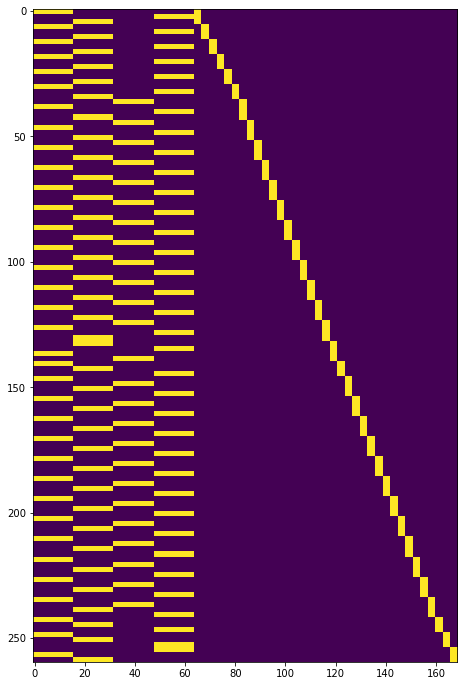

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.imshow(np.not_equal(J, np.zeros(J.shape))) #Jacobian

209.16430538121483
400
-58.33083755555968
24028


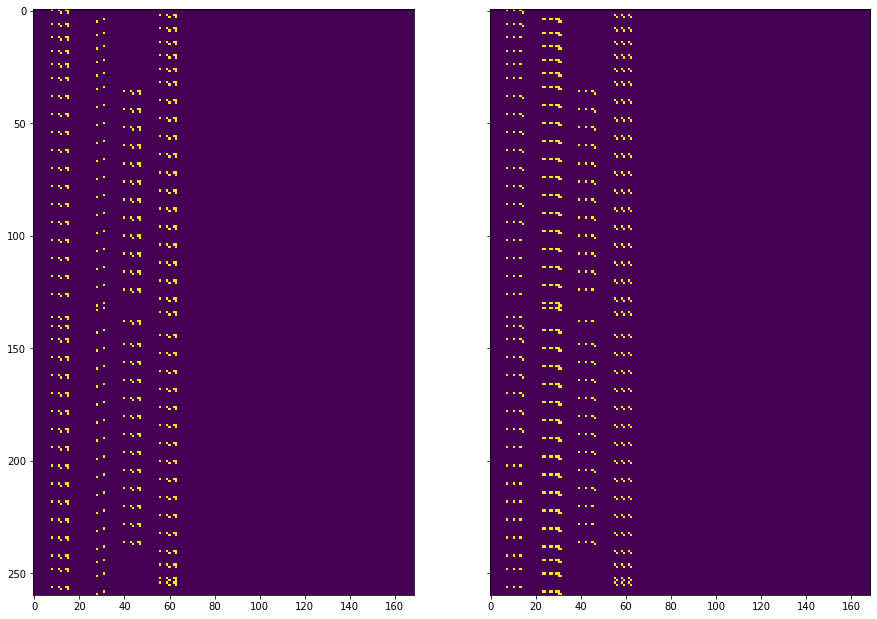

In [12]:
print(np.max(J))
print(np.argmax(J))
print(np.min(J))
print(np.argmin(J))

# plt.figure(figsize=(20,20))
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.imshow(np.greater(J, np.ones((J.shape)))) # Greater Than 1 elements
ax2.imshow(np.less(J, -1*np.ones((J.shape)))) # Less Than -1 elements


In [ ]:
J_sensor = J[:,:64]
J_ground = J[:,64:]
print(J_sensor.shape)
print(J_ground.shape)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1.imshow(J_sensor)
ax2.imshow(J_ground)

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(np.not_equal(np.dot(J.T,J), np.zeros((J.shape[1], J.shape[1])))) # Normal Equation

### Compute the Weight Matrix
#### According to the weighted Normal equation (J.TWJ), W needs to be a square matrix the size of (# of measures)x2. So it is the weight of the observations. In ISIS, the weight of the observations are an inverted function of the size of the pixels on the focal plane (resolution). However, in csm we do not have access to that information. 
#### For the time being, since we are working exclusively with CTX images we are going to set the weight matrix equal to the identity matrix -> all observations have the same weight.

In [13]:
# for key, sensor in sensors.items():
#     covar = sensor.getCovarianceMatrix()
#     covar = np.reshape(list(covar), (16,16))
#     weight = np.linalg.inv(covar)
#     print(weight.shape)
#     print(weight)
#     break

W = np.eye(meas*2)
W.shape

(260, 260)

### Calculate the Residuals

In [14]:
# I just bulk grabbed values from the df to make the Jacobian
# I think it is safe to do that again 

control_network = df

# grab line sample values of the measures in the df
meas_line = np.array(control_network['line'].values)
meas_sample = np.array(control_network['sample'].values)
# stuff them into one vector line sample line sample
meas_ls = np.zeros((1,2*len(control_network)))[0]
meas_ls[::2] = meas_line
meas_ls[1::2] = meas_sample

# back project ground points
cn_sensors = [sensors[sn] for sn in control_network['serialnumber']]
ground_points = [csmapi.EcefCoord(x, y, z) for 
                 x, y, z in zip(control_network['adjustedX'],
                                control_network['adjustedY'],
                                control_network['adjustedZ'])]
gp_line = []
gp_sample = []
for sensor, gp in zip(cn_sensors, ground_points):
    img_coord = sensor.groundToImage(gp)
    gp_line.append(img_coord.line)
    gp_sample.append(img_coord.samp)
    
gp_line = np.array(gp_line)
gp_sample = np.array(gp_sample)
# stuff them into one vector line sample line sample
gp_ls = np.zeros((1,2*len(control_network)))[0]
gp_ls[::2] = gp_line
gp_ls[1::2] = gp_sample

# compare
V = gp_ls - meas_ls
print(V)

[24310.77331393  5781.32556815 66386.85944392 24477.82813578
 61697.52995774 -3850.69400608 24693.09889407  3979.97618826
 66809.07423469 23038.98671835 62064.99732782 -5656.1205301
  8607.19702341  4714.2196969  49748.21395913 23758.45889798
 45977.96005535 -4900.49431478  8990.38901787  2929.14218152
 50179.34373588 22319.83544143 46344.64066369 -6689.60771387
  9370.53184807  1119.95729421 50607.64342986 20837.79603425
 46709.14702386 -8488.03087145  5947.61170628  2282.9202359
 46966.13962519 21867.59785778 43295.42520034 -7359.33171226
 18669.1493968  12741.74543108 22691.3614213   4571.98220662
 64682.02340892 23517.40462802 60067.75322359 -5053.10377025
 19059.64321782 11044.21171594 23071.98788752  2780.07251128
 65103.43598616 22074.50764405 60433.95792386 -6847.43800874
 15189.25065202 13936.47463955 19234.6722989   5842.24936223
 61006.31409967 24557.51142794 56621.29617801 -3775.91525368
 15583.18908446 12229.79453668 19618.86722083  4039.33259536
 61429.88499232 23104.1379

### Bundle Iteration

In [15]:
N = J.T.dot(W).dot(J)
# print(N)
dX = np.linalg.inv(N).dot(J.T).dot(W).dot(V)
print(dX.shape)

(169,)


In [16]:
print(dX)

[-4.37051367e+13  1.01131825e+14  1.72090838e+14  1.55739248e+13
  3.84252539e+13 -3.07710857e+13 -4.12232914e+12  1.92536263e+12
 -1.86302139e+10 -1.56272017e+12 -7.37143161e+11  5.51608467e+09
  3.41579384e+09  1.74986337e+10  1.14784057e+09  2.22425402e+09
  1.66982774e+14  5.53215743e+13  8.34072144e+13 -6.95301561e+13
 -8.06990245e+13  8.73512453e+13 -6.43425049e+11 -8.25855512e+12
 -1.25295449e+10  3.46295894e+12  3.94916118e+12  2.37781474e+10
 -5.50568588e+10 -1.75388170e+11 -9.88072399e+09  1.91565492e+10
  3.06535901e+12 -1.30263327e+14 -1.10452474e+14 -9.33669042e+11
  3.57760888e+13  1.74974634e+12  6.32461436e+12 -1.14781231e+11
  7.77598129e+09 -1.46356526e+12  2.02780101e+10 -4.20640779e+09
  7.96167156e+07  1.18468209e+09  3.48625098e+08 -5.78234007e+09
  3.87916717e+13 -1.62047541e+14 -6.98115387e+12 -1.69262095e+13
  4.62228806e+13  1.22087938e+13  6.25561483e+12 -1.71927912e+12
  5.88753201e+10 -2.02408281e+12  7.76315124e+11 -3.35642024e+10
  9.42511226e+08 -7.26703

### Redundancy Number Calculation

### Visualizing Ground Points

In [ ]:
import pyproj

a = 3396190
b = 3376200
ecef = pyproj.Proj(proj='geocent',
                   a=a,
                   b=b)
lla = pyproj.Proj(proj='longlat',
                  a=a,
                  b=b)

# Compute the lat/lons from the ecef coords
lons, lats, alts = pyproj.transform(ecef, lla, df['adjustedX'].values, df['adjustedY'].values, df['adjustedZ'].values)
df['longitude'] = lons
df['latitude'] = lats
df['altitudes'] = alts


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

for isn, group in df.groupby('serialnumber'):
    x = list(group.adjustedX)
    y = list(group.adjustedY)
    z = list(group.adjustedZ)
    lat = list(group.latitude)
    lon = list(group.longitude)
    alts = list(group.altitudes)
    
    print(isn)
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(x, y, z)
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(lat, lon, alts)
    
#     ax.view_init(0,45)

    

### Jigsaw Parameter, For Referance

In [ ]:
jigsaw fromlist=bundled_cubes_100CV.lis cnet=wTestingGround.100Covar.bundle.filtered.net 
onet=wTestingGround.100Covar.bundle.filtered.bundle.net file_prefix=bundle2_100CV radius=yes 
twist=yes camsolve=accelerations overexisting=yes camera_angles_sigma=0.25 camera_angular_velocity_sigma=.1 
camera_angular_acceleration_sigma=.01 point_radius_sigma=50 update=yes


### Get Current Parameters

In [ ]:
sensor = sensors['MRO/CTX/1085197697:073']
parameter_values = [sensor.getParameterValue(i+17) for i in range(sensor.getNumParameters())]
print(parameter_values)

In [ ]:
# GET ALL PARAMETER VALUES (position x shift, position y shift, etc.)
for key in sensors:
    sensor = sensors[key]
    parameter_values = [sensor.getParameterValue(i) for i in range(sensor.getNumParameters())]
    print(parameter_values)